In [228]:
# !pip install umap-learn

In [56]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer, AutoModelForMaskedLM

import umap

In [57]:
dataset = datasets.load_dataset('bookcorpus')['train']

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name, output_attentions=True)

dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [14]:
word_reprs = model.base_model.embeddings.word_embeddings.weight.detach()
biases = model.cls.predictions.decoder.bias.detach()

weight norms, min: 0.7657114863395691, max: 2.0445971488952637
min norms: ['[SEP]', '.', ';', 'the', ',', 'of', 'his', '(', 'in', 'her']
max norms: ['690', '930', '##lland', '840', '##lho', '##anor', '[CLS]', '##rdon', '##omba', '670']
bias norms, min: -4.510498523712158, max: 2.488515853881836
min norms: ['[SEP]', '[MASK]', '[CLS]', 'nedra', '##peration', '##urbed', '##⁄', '##nction', 'janeiro', '##rricular']
max norms: ['a', 'it', 'in', '"', '-', '##s', 'and', '.', 'the', ',']


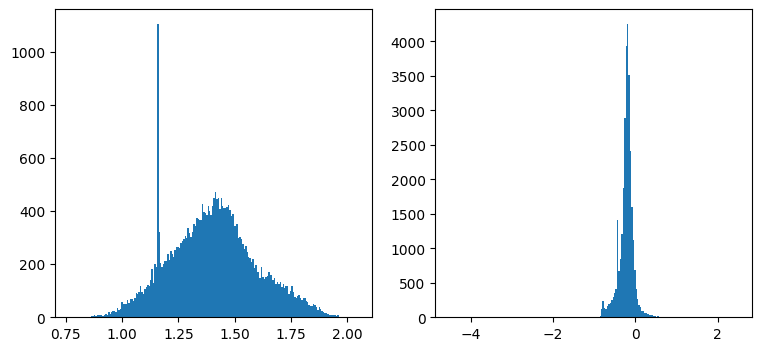

In [16]:
_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=200)

# bias stats

indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=200)

In [17]:
# %%time
from collections import defaultdict

def get_projection(representations, n_neighbors=10, methods=['euclidean', 'cosine'], n_jobs=16):
  transed_repr = {}
  for method in methods:
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric=method, n_jobs=n_jobs)
    transed_repr[method] = reducer.fit_transform(representations)
  return transed_repr

def grouped_get_projection(representations_dict_groupNames, **kwargs):
  
  size_repr_len_pairs = [[name, reprs, reprs.shape[0]] for name, reprs in representations_dict_groupNames.items()]
  names, reprs, lengths = [*zip(*size_repr_len_pairs)]

  transeds = get_projection(torch.cat(reprs))
  to_return = defaultdict(defaultdict)
  for method, transed in transeds.items():
    accum_length = 0
    for name, length in zip(names, lengths):
      to_return[method][name] = transed[accum_length:accum_length+length]
      accum_length += length
    
  return to_return
  

pivot = torch.zeros(1, word_reprs.shape[1])
pivot[0, 0] = 1
origin = torch.zeros(1, word_reprs.shape[1])

transeds_dict_methods_groupNames = grouped_get_projection({'word': word_reprs, 'pivot': pivot, 'origin': origin})

# transeds_dict_methods = get_projection(torch.cat([word_reprs, pivot]))
# transed_words_dict_methods = {name: transed[:-1] for name, transed in transeds_dict_methods.items()} #transed word representations in a dict with methods as keys
# transed_pivots_dict_methods = {name: transed[-1:] for name, transed in transeds_dict_methods.items()}
vector_norms = np.linalg.norm(word_reprs, axis=1)
# del model

In [18]:
from utils.inspecting import inspect_direction_representing_words

def draw_and_annotate(ax, points, word_pos_pairs):
  image = ax.scatter(*points.T, marker='.', edgecolors='none', cmap=cmap, c=norms, alpha=.2, vmin=0)

  for word, x_y in word_pos_pairs:
    ax.annotate(word, x_y, alpha=.7)

In [19]:
# vector_norms = np.linalg.norm(word_reprs, axis=1)
# # angle_norms = np.linalg.norm(angle_reprs, axis=1)

# # sampling_position = np.random.randint(0, len(dataset))
# # samples = dataset[sampling_position:sampling_position+3]['text']
# # sequences = tokenizer(samples, add_special_tokens=False)['input_ids']

# representations = {
#     'word_vector': (transed_word, vector_norms),
#     # 'word_angle': (transed_angle, angle_norms)
# }
# methods = ['euclidean', 'cosine']

# fig, axes = plt.subplots(len(methods), max(2, len(representations)), figsize=[12*len(methods),12*len(representations)])
# cmap = plt.get_cmap('rainbow')
# for i, repr_name in enumerate(representations):
#   for j, method in enumerate(methods):
#     ax = axes[i, j]
#     representation, norms = representations[repr_name]

#     ax.set_title(f'{repr_name}, {method}')

#     draw_and_annotate(ax, representation[method], zip(words, representation[method][ids]))
    
#     fig.colorbar(image, cmap=cmap, ax=ax)

#     # for seq in sequences:
#     #   positions = representation[method][seq]
#     #   ax.plot(*positions.T, alpha=.3)
#     #   ax.scatter(*positions.T, marker='x')

#     #   tokens = tokenizer.convert_ids_to_tokens(seq)

#     #   for token, pos in zip(tokens, positions):
#     #     # print(token, pos)
#     #     ax.annotate(token, pos)



# # fig.savefig(f'image/umap-{subpath}-epoch_{epoch_num}-{batch_num}.png')

0.4445233

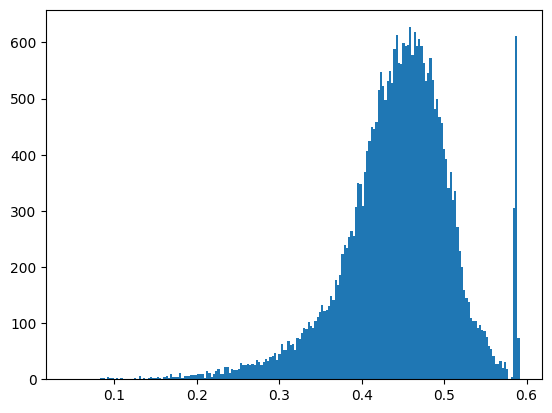

In [23]:
sim = cosine_similarity(word_reprs)
offdiag_mean = (sim.sum(axis=1) - 1) / (sim.shape[0] - 1)
plt.hist(offdiag_mean, bins=200)
offdiag_mean.mean()

In [24]:
wordIdPairs_dict_samplingMethod = {}

In [25]:
far_ids = np.where(offdiag_mean < -0.05)[0]
tokens = tokenizer.convert_ids_to_tokens(far_ids)
wordIdPairs_dict_samplingMethod['far_tokens'] = list(zip(tokens, far_ids))

In [26]:
words = ['[MASK]', ',', '.', '[SEP]', '[PAD]', '[CLS]', 'the', 'and', 'and', 'i', 'her', 'he', 'him', 'she', 'are', 'is', 'they', 'a', 'am']

samples = np.random.randint(0, tokenizer.vocab_size, [70])

word_ids = tokenizer.convert_tokens_to_ids(words)
sample_tokens = tokenizer.convert_ids_to_tokens(samples)
words = words + sample_tokens
ids = word_ids + samples.tolist()

wordIdPairs_dict_samplingMethod['random+most_common'] = list(zip(words, ids))
print(words, ids, sep='\n')

['[MASK]', ',', '.', '[SEP]', '[PAD]', '[CLS]', 'the', 'and', 'and', 'i', 'her', 'he', 'him', 'she', 'are', 'is', 'they', 'a', 'am', 'intriguing', 'alcohol', 'onslaught', 'alpine', 'ি', 'stomach', 'attracting', 'quite', 'reducing', 'karma', 'casper', '[unused719]', '279', 'inspection', 'wheelbase', '[unused842]', '1811', 'conversations', '##stock', '##shing', 'shaping', 'jolted', 'vincenzo', 'ム', 'appointments', 'canberra', 'approve', 'international', 'slots', '##rford', 'alive', '##伊', 'reacted', 'bruno', 'mauritius', 'glaciers', '##tyn', 'sending', '##parts', 'globe', 'ச', 'whole', '##psy', '[unused835]', 'jewelry', '##eka', 'yamaha', 'longitudinal', 'frowns', 'commendation', 'commandos', 'cottage', '##lani', 'ज', 'computation', 'psi', 'outcome', 'costumes', '[unused948]', '##ய', 'capabilities', '##rgo', 'dozens', 'cha', '##grin', '##ber', 'crypt', 'dade', 'lust', 'albums']
[103, 1010, 1012, 102, 0, 101, 1996, 1998, 1998, 1045, 2014, 2002, 2032, 2016, 2024, 2003, 2027, 1037, 2572, 23

In [41]:
sampled_vecs = np.random.rand(150, word_reprs.shape[1])
sampled_args = cosine_similarity(sampled_vecs, word_reprs).argmax(axis=1)

sample_tokens = tokenizer.convert_ids_to_tokens(sampled_args)

wordIdPairs_dict_samplingMethod['random_vectors'] = list(zip(sample_tokens, sampled_args))
print(sample_tokens, sampled_args, sep='\n')

['[CLS]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[SEP]', '[SEP]', '[CLS]', '[CLS]', '[MASK]', '[SEP]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[SEP]', '[CLS]', '[SEP]', '[CLS]', '[MASK]', '[CLS]', '[SEP]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[SEP]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[SEP]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[SEP]', '[SEP]', '[CLS]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[CLS]', '[MASK]', '[CLS]', '[CLS]', '[SEP]', '[CLS]', '[CLS]', '[SEP]', '[SEP]', '[MASK]', '[CLS]', '[MASK]', '[MASK]', '[CLS]', '[CLS]', '[CLS]', '[CLS]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '[MASK]', '[SEP]', '[CLS]', '[CLS]', '[MA

In [42]:
wordIdPairs_dict_samplingMethod['end_with_ed'] = [[key, id_] for key, id_ in tokenizer.vocab.items() if key[-2:] == 'ed']

In [54]:
cmap = plt.get_cmap('rainbow')

def plot_basics(axes, transeds_dict_groupNames, title_prefix=None):
  for ax, (methodName, transeds_dict_groupNames) in zip(axes, transeds_dict_methods_groupNames.items()):
    transeds_dict_groupNames = transeds_dict_groupNames.copy()
    transed_vecs = transeds_dict_groupNames.pop('word')
  
    image = ax.scatter(*transed_vecs.T, marker='.', edgecolors='none', s=3, c=norms, cmap=cmap, alpha=.4, vmin=0)
    fig.colorbar(image, ax=ax, fraction=0.05, pad=0.05)
  
    ax.scatter(*transeds_dict_groupNames['pivot'].T, marker='+', color='red', alpha=.7, label='pivot')
    ax.scatter(*transeds_dict_groupNames['origin'].T, marker='+', color='blue', alpha=.7, label='origin')
    ax.set_title(f"{title_prefix}: {methodName}")
    ax.legend()

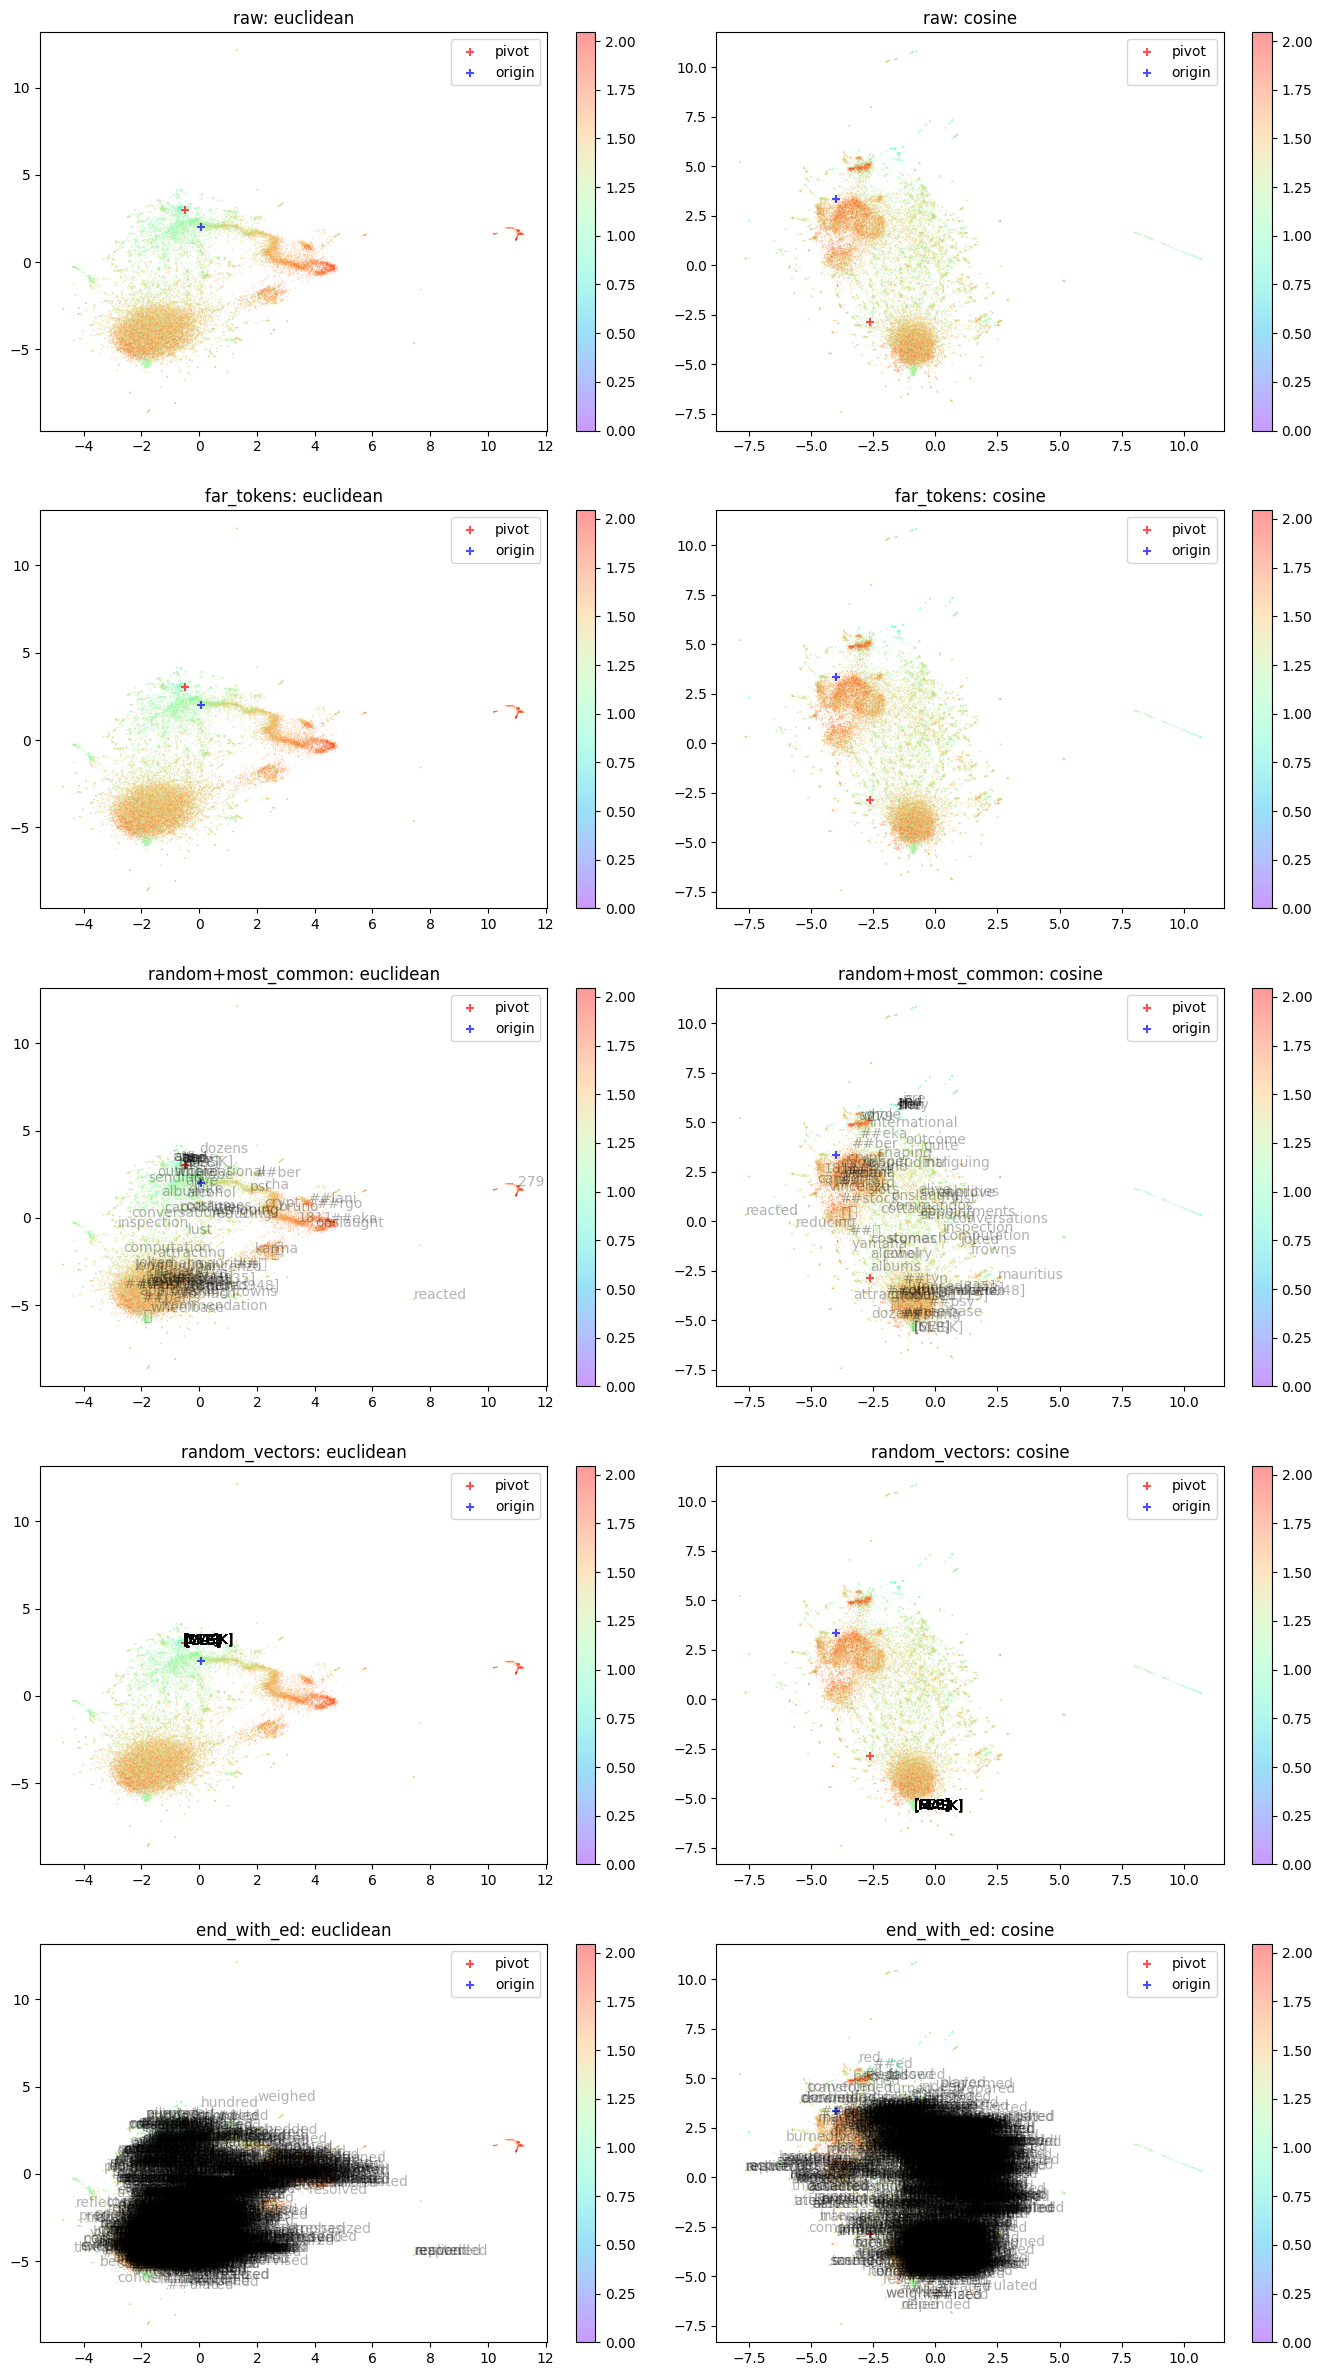

In [55]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(1+len(wordIdPairs_dict_samplingMethod), 2, figsize=[16, 6*(1+len(wordIdPairs_dict_samplingMethod))])

plot_basics(axes[0], transeds_dict_methods_groupNames, 'raw')

for axes_or_a_row, (samplingMethodName, word_id_pairs) in zip(axes[1:], wordIdPairs_dict_samplingMethod.items()):
  plot_basics(axes_or_a_row, transeds_dict_methods_groupNames, samplingMethodName)

  for ax, (ProjectingMethodName, transeds_dict_groupNames) in zip(axes_or_a_row, transeds_dict_methods_groupNames.items()):
    # print(word_id_pairs)
    for word, id_ in word_id_pairs:
      # print(word, id_)
      ax.annotate(word, transeds_dict_groupNames['word'][id_], alpha=.3)